In [14]:
import torch
import slayerSNN as snn
from spikefi.models import DeadNeuron, ParametricNeuron, SaturatedSynapse, BitflippedSynapse
from spikefi.fault import FaultSite, Fault
from spikefi.core import Campaign
from spikefi import visual
import demo as cs
from demo import shape_in, test_loader

# Initialization
file_path = "/shares/bulk/vgandham/SpikeFI/quantized_model.pt" 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ",device)

net: cs.Network = torch.load(file_path,map_location=device)
net.eval()

# ✅ Load test dataset
test_loader = cs.test_loader
print(f"Test set size: {len(test_loader.dataset)} images")

_, spikes, targets, labels = next(iter(test_loader))

print(f"Spikes shape: {spikes.shape}") # [Batch, Timesteps, Height, Width, Time bins] 
print(f"Targets shape: {targets.shape}") # (batch_size,target_prob,1, 1,)
print(f"Labels shape: {labels.shape}")# correct labels for each image in the batch


Device:  cuda
Test set size: 10000 images
Spikes shape: torch.Size([12, 2, 34, 34, 300])
Targets shape: torch.Size([12, 10, 1, 1, 1])
Labels shape: torch.Size([12])


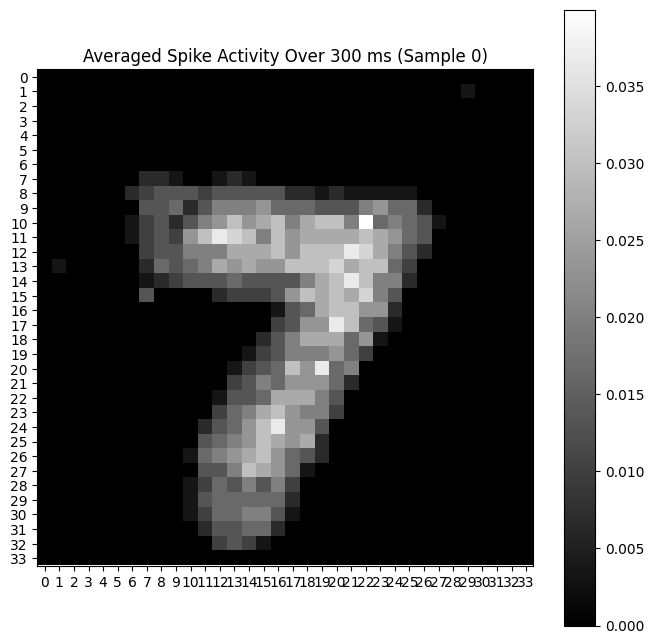

Label:  tensor(7)


In [15]:
# Visualizing the input dataset

import matplotlib.pyplot as plt
import numpy as np

# ✅ Load one batch from test_loader
_, spikes, targets, labels = next(iter(cs.test_loader))

# ✅ Select one sample (first image in batch)
sample_idx = 0  # Choose the first image in batch
timestep = 0  # Choose first timestep (since all timesteps will be summed, any timestep index is fine)

# ✅ Compute the average spike activity over all 300 time bins
spike_image_avg = spikes[sample_idx, timestep, :, :, :].sum(dim=-1).cpu().numpy() / 300  # Average over time bins

# ✅ Plot the averaged spike image with values
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(spike_image_avg, cmap="gray", interpolation="nearest")  # Display the averaged matrix

# ✅ Add colorbar to visualize intensity
plt.colorbar(im, ax=ax)

# ✅ Set grid ticks
ax.set_xticks(np.arange(spike_image_avg.shape[1]))
ax.set_yticks(np.arange(spike_image_avg.shape[0]))

# # ✅ Display the average values on the grid
# for i in range(spike_image_avg.shape[0]):  # Height
#     for j in range(spike_image_avg.shape[1]):  # Width
#         ax.text(j, i, f"{spike_image_avg[i, j]:.2f}", ha="center", va="center", color="red", fontsize=6)

plt.title(f"Averaged Spike Activity Over 300 ms (Sample {sample_idx})")
plt.show()

print('Label: ', labels[sample_idx])



tensor([0., 1.])


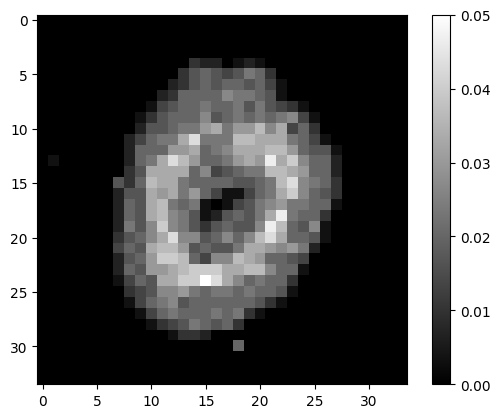

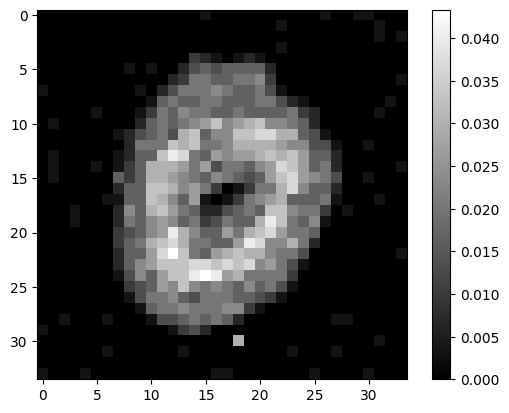

Label:  tensor(0)


In [16]:
# ✅ Load one batch from test_loader
_, spikes, targets, labels = next(iter(cs.test_loader))

# ✅ Select one sample (first image in batch)
sample_idx = 3  # Choose the first image in batch
timestep = 0  # Choose first timestep

print(spikes.unique())

# ✅ Extract a single time slice
spike_image = spikes[sample_idx, timestep, :, :, :].sum(dim=-1).cpu().numpy() / 300
spike_image1 = spikes[sample_idx, 1, :, :, :].sum(dim=-1).cpu().numpy() / 300

# Likely two images must have been taken during 1 msec, and repated for 300 msec

# ✅ Plot the image
plt.imshow(spike_image, cmap="gray")
plt.colorbar()
plt.show()

plt.imshow(spike_image1, cmap="gray")
plt.colorbar()
plt.show()

print('Label: ', labels[sample_idx])


In [17]:
# Testing
# ✅ Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

stats = snn.utils.stats()
spike_loss = snn.loss(cs.net_params).to(device)

for i, (_, input, target, label) in enumerate(cs.test_loader, 0):
    input = input.to(device)
    target = target.to(device)

    output = net.forward(input)

    stats.testing.correctSamples += torch.sum(snn.predict.getClass(output) == label).data.item()
    stats.testing.numSamples += len(label)

    loss = spike_loss.numSpikes(output, target)
    stats.testing.lossSum += loss.cpu().data.item()
    stats.print(0, i)

stats.update()

Using device: cuda

Epoch :          0(i =       0)
None
loss = 7.5                                accuracy = 0.16667                  

Epoch :          0(i =       1)
None
loss = 7.5                                accuracy = 0.125                    

Epoch :          0(i =       2)
None
loss = 7.5                                accuracy = 0.13889                  

Epoch :          0(i =       3)
None
loss = 7.5                                accuracy = 0.10417                  

Epoch :          0(i =       4)
None
loss = 7.5                                accuracy = 0.1                      

Epoch :          0(i =       5)
None
loss = 7.5                                accuracy = 0.11111                  

Epoch :          0(i =       6)
None
loss = 7.5                                accuracy = 0.095238                 

Epoch :          0(i =       7)
None
loss = 7.5                                accuracy = 0.083333                 

Epoch :          0(i =       8)
None
loss = 

In [51]:
# Testing with a single instance

# ✅ Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

stats = snn.utils.stats()
spike_loss = snn.loss(cs.net_params).to(device)

_, input, targets, label = next(iter(cs.test_loader))

input = input.to(device)
target = targets.to(device)

output = net.forward(input)

stats.testing.correctSamples += torch.sum(snn.predict.getClass(output) == label).data.item()
stats.testing.numSamples += len(label)

loss = spike_loss.numSpikes(output, target)
stats.testing.lossSum += loss.cpu().data.item()

stats.print(0, 0)

Using device: cuda

Epoch :          0(i =       0)
None
loss = 0.13792                            accuracy = 1                        


In [53]:
# Injecting Faults

fx = Fault(DeadNeuron(), FaultSite('SF2'))
fy = Fault(SaturatedSynapse(10), FaultSite('SF1'))
fz = Fault(ParametricNeuron('theta', 0.5))

cmpn = Campaign(net, shape_in, net.slayer)
cmpn.inject([fx])
cmpn.then_inject([fy, fz])

# Run
cmpn.run(test_loader)

for perf in cmpn.performance:
    print(perf.testing.maxAccuracy * 100.0)


+-----------+------------+----------+
|  Batch #  | Total time | Progress |
|    1/834  |   0.00 % |
+-----------+------------+----------+


+-----------+------------+----------+
|  Batch #  | Total time | Progress |
|    6/834  |      1 sec |   0.60 % |
+-----------+------------+----------+


+-----------+------------+----------+
|  Batch #  | Total time | Progress |
|   21/834  |      2 sec |   2.46 % |
+-----------+------------+----------+


+-----------+------------+----------+
|  Batch #  | Total time | Progress |
|   40/834  |      3 sec |   4.68 % |
+-----------+------------+----------+


+-----------+------------+----------+
|  Batch #  | Total time | Progress |
|   54/834  |      4 sec |   6.35 % |
+-----------+------------+----------+


+-----------+------------+----------+
|  Batch #  | Total time | Progress |
|   71/834  |      5 sec |   8.39 % |
+-----------+------------+----------+


+-----------+------------+----------+
|  Batch #  | Total time | Progress |
|   86/834  

## **1. What Happened in the Experiment?**
- **I defined three types of faults**:  
  - `DeadNeuron()` in layer **SF2**  
  - `SaturatedSynapse(10)` in layer **SF1**  
  - `ParametricNeuron('theta', 0.5)`  

- **I injected faults in two rounds**:
  1. **First round** → Inject only `DeadNeuron()`
  2. **Second round** → Inject `SaturatedSynapse(10)` and `ParametricNeuron('theta', 0.5)`

- **I ran the faulty network on the test dataset** and logged the accuracy.

---

## **2. Understanding the Progress Log**
This log:
```
|  Batch #  | Total time | Progress |
|    1/834  |   0.00 %   |
...
|  834/834  |    53 sec  | 100.00 % |
```
🔹 **Indicates that the fault-injected network was tested on all 834 batches** of my test dataset.  
🔹 Each batch is a subset of my **10,000 test images** (so batch size ≈ 12).  
🔹 The test loop completed in **53 seconds**.

---

## **3. Understanding the Accuracy Results**
At the end, I got:
```
88.52
97.77
```
This means:
1. **First Fault Injection (DeadNeuron)**
   - Accuracy dropped **from 97.77% to 88.52%**.
   - **Why?** Because some neurons in **SF2** stopped firing, disrupting predictions.
  
2. **Second Fault Injection (Saturated Synapse + Parametric Neuron)**
   - Accuracy **remains 97.77%**.
   - **Why?** Maybe the network compensated for the changes, or **SF1 + theta perturbations were not severe enough**.

---

## **4. Next Steps: What Can You Try?**
🔹 **Try injecting faults in different layers** (e.g., `SC1`, `SC2`) and observe accuracy changes.  
🔹 **Increase the fault severity** (e.g., `SaturatedSynapse(100)`, `theta = 0.1`).  
🔹 **Test single vs. combined faults** to see interaction effects.  
🔹 **Visualize activations** before and after fault injection to understand their impact.

---

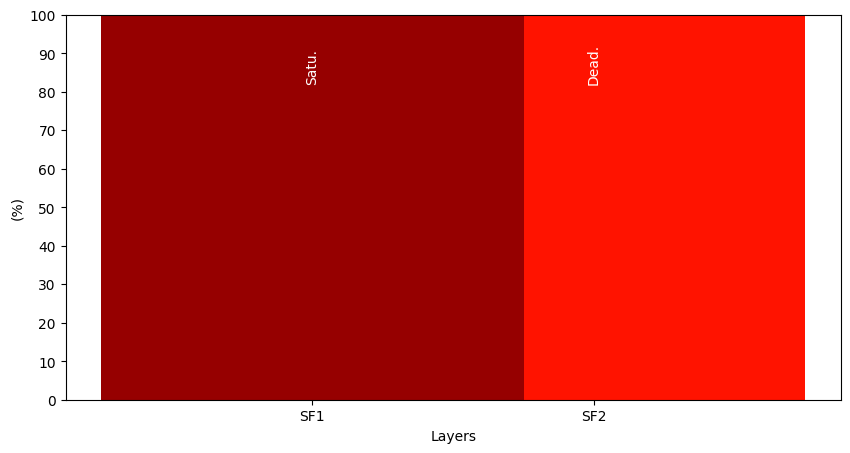

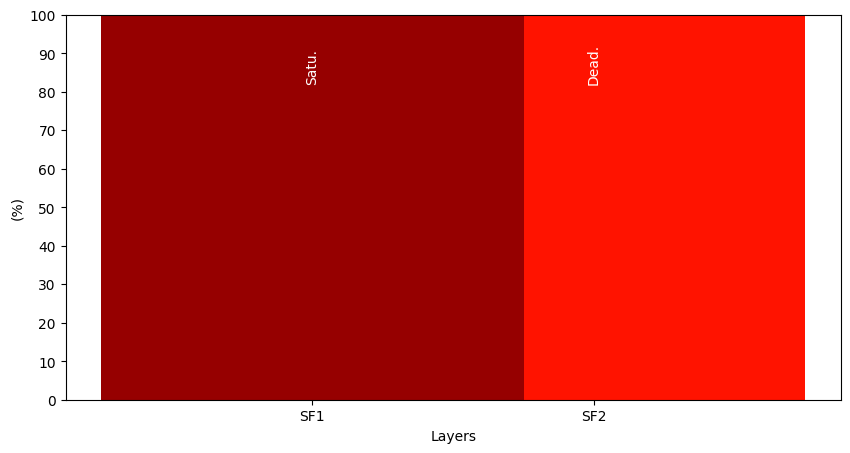

In [54]:
visual.bar([cmpn.export()]) 

In [55]:
# Extending the library 

fx = Fault(DeadNeuron(), FaultSite('SF2'))
fy = Fault(SaturatedSynapse(10), FaultSite('SF1'))
fz = Fault(ParametricNeuron('theta', 0.5))


Hello
